# Bayesian models for Machine Learning

Suppose we want to predict the probability that sample $x$ has label $y$. This is a probability estimation problem that can be written:
$$\mathbb{P}(Y=y|X=x)$$

According to Bayes' theorem, we have:
$$\mathbb{P}(Y=y|X=x) =\frac{\mathbb{P}(X=x|Y=y)\cdot\mathbb{P}(Y=y)}{\mathbb{P}(X=x)}$$
$$\textrm{posterior} = \frac{\textrm{likelihood}\cdot\textrm{prior}}{\textrm{evidence}}$$

<div class="alert alert-success">
**Bayesian inference** is the problem of estimating this **posterior distribution**.<br>
In plain words, it consists in estimating the probability of label $y$, given an input $x$, using previously seen data to estimate the **likelihood** of an $x$ input associated to label $y$ and the general **prior** probability of observing label $y$.
</div>

Note that Bayesian inference applies both to classification and regression.

The goal of Bayesian inference is to estimate the label distribution for a given $x$ and use them to predict the correct label, so it is a *probabilistic approach to Machine Learning*.

The Bayesian predictor (classifier or regressor) returns the label that maximizes the posterior probability distribution.

In this notebook, we will go through two different Bayesian prediction methods: Naive Bayes Classification and Gaussian Processes.

1. [Naive Bayes Classification](#sec1)
    1. [The naive Bayes assumption](#sec1-1)
    2. [Naive Bayes classifiers in scikit-learn](#sec1-2)
    3. [The "spam or ham?" example](#sec1-3)
2. [Gaussian Processes](#sec2)
    1. [A reminder on Gaussian distributions](#sec2-1)
    2. [Back to the regression problem](#sec2-2)
    3. [Gaussian Processes for classification](#sec2-3)
3. [Examples](#sec3)
    1. [Spam or ham?](#sec3-1)
    2. [NIST](#sec3-2)

# 1. <a id="sec1"></a> Naive Bayes Classification

## 1.2 <a id="sec1-1"></a>The naive Bayes assumption

Let's start with some illustrative data. We consider an artificial data set of 9 individuals. The first column in our data set is the sex ($S=0$ for male, 1 for female), the second is the height $H$ (in meters), the third is the weight $W$ (in kilos) and the last is the foot size $F$ (in centimeters).

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
fig_size=(10, 10)

data = np.loadtxt("sex_classif.csv")
data

array([[  0.  ,   1.82,  82.  ,  30.  ],
       [  0.  ,   1.8 ,  86.  ,  28.  ],
       [  0.  ,   1.7 ,  77.  ,  30.  ],
       [  0.  ,   1.8 ,  75.  ,  25.  ],
       [  1.  ,   1.52,  45.  ,  15.  ],
       [  1.  ,   1.65,  68.  ,  20.  ],
       [  1.  ,   1.68,  59.  ,  18.  ],
       [  1.  ,   1.75,  68.  ,  23.  ],
       [  1.  ,   1.58,  49.  ,  19.  ]])

We would like to answer the question: is $(H=1.81, W=59, F=21)$ male or female?

Let's try to estimate $\mathbb{P}(S=0|H=1.81, W=59, F=21)$.

According to Bayes' theorem, the probability that a person that measures 1.81m, weights 59kgs and has a foot size of 21cm is male, is actually the likelihood of observing a person with such features among males, multiplied by the probability of observing males in the population, divided by the probability of observing an individual with these features.

That's a long sentence. Let's write that mathematically:
$$\mathbb{P}(S=0|H=1.81, W=59, F=21) = \frac{\mathbb{P}(H=1.81, W=59, F=21 | S=0)\cdot \mathbb{P}(S=0)}{\mathbb{P}(H=1.81, W=59, F=21)}$$

Let's make that more readable and more general:
$$\mathbb{P}(S|H, W, F) = \frac{\mathbb{P}(H,W,F | S)\cdot \mathbb{P}(S)}{\mathbb{P}(H,W,F)}$$

Interestingly, since our goal is only to compare the probabilities for $S=0$ and $S=1$, the denominator in the last equation won't be relevant. So we are left with two terms to estimate, given the available data:
- $\mathbb{P}(S=0)$: the prior - the probability that any individual is $S=0$, regardless of his/her physical attributes;
- $\mathbb{P}(H=1.81, W=59, F=21 | S=0)$: the likelihood of meeting somebody with the specified features, given that his/her sex is $S=0$.

The prior, in this case, is easy to estimate by comparing the frequence of male and female individuals in the population.
\begin{gather*}
\mathbb{P}(S=0) = \frac{4}{9}\\
\mathbb{P}(S=1) = \frac{5}{9}
\end{gather*}
Technically, the estimate above is obtained by [*maximum likelihood estimation*](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation).

The likelihood, however, is a bit trickier. Can we directly estimate the **joint probability** of the 3 variables $(H,W,F)$?

Theoretically, we can. We can assume that among male individuals, $(H,W,F)$ are distributed according to a multivariate Normal distribution, with mean $\mu=(\mu_H, \mu_W, \mu_F)$ and covariance matrix $\Sigma$. The trick is then to estimate $\mu$ and $\Sigma$.

As a matter of fact, estimating $\mu$ and $\Sigma$ without further hypothesis would require quite a lot of data, especially because $\Sigma$ captures the **correlation** between $H$, $W$ and $F$.

Let's rephrase this. With some basic probabilities, we have:
\begin{align*}
\mathbb{P}(H,W,F | S) = &\mathbb{P}(H | S)\\
& \cdot \mathbb{P}(W | S, H) \\
& \cdot \mathbb{P}(F | S, H, W)
\end{align*}

Those three probabilities are univariate probabilities, much easier to estimate. However, the first one is a function of $S$ only, the second one depends on $S$ and $H$ and the third one depends on $S$, $H$ and $W$. To get an accurate estimate of the third one, we would need samples of the distribution of $F$ in enough points in the space of $(S,H,W)$ to cover it reasonably. This would require a number of data points that is exponential in the number of variables. That's what is called the **curse of dimensionality**, which makes this estimation problem difficult.

Let's make this concrete. Suppose we discretize $H$, $W$ and $F$ in 10 bins each and suppose we require 100 samples to get a correct estimate of $\mathbb{P}(F | S, H, W)$ for any given value of $(F, S, H, W)$. Then we need $100\cdot 10^3\cdot 2$ samples to correctly estimate this probability for all possible values of $(F, S, H, W)$. More generally, if we had $n$ continuous features rather than just three, we would require a number of data points that is exponential in $n$.

To circumvent this problem, we are going to make a very **naive** assumption (hence the name of the method). We are going to assume that the weight, the height and the foot size are totally independent variables, that is the probability that a person be 1.85m is the same whatever his/her weight and foot size.

Obviously, this hypothesis is very strong and clearly does not hold is most real-world cases. But we will assume it nonetheless. In this case, the likelihood estimation becomes:
\begin{align*}
\mathbb{P}(H,W,F | S) = &\mathbb{P}(H | S)\\
& \cdot \mathbb{P}(W | S) \\
& \cdot \mathbb{P}(F | S)
\end{align*}

Each of these probabilities now only depend on the label $S$ and are much easier to estimate from the data. This **conditional independence** assumption is called the **naive Bayes hypothesis**. It allow us to give a (very bad) estimate of $\mathbb{P}(X | Y)$ and hence of $\mathbb{P}(Y|X)$.

$$\mathbb{P}(S|H, W, F) = \frac{\mathbb{P}(H | S)\cdot \mathbb{P}(W | S) \cdot \mathbb{P}(F | S)\cdot \mathbb{P}(S)}{\mathbb{P}(H, W, F)}$$

Or, in our case:

$$\mathbb{P}(S=0|H=1.81, W=59, F=21) = \frac{\mathbb{P}(H=1.81 | S=0)\cdot \mathbb{P}(W=59 | S=0) \cdot \mathbb{P}(F=21 | S=0)\cdot \mathbb{P}(S=0)}{\mathbb{P}(H=1.81, W=59, F=21)}$$

The **naive Bayes classifier** is then the classifier that estimates all class probabilities and returns the one with maximum probability.

$$f(H, W, F) = \arg\max_{s} \mathbb{P}(S=s|H,W,F) = \arg\max_{s} \mathbb{P}(H|S=s)\cdot \mathbb{P}(W|S=s) \cdot \mathbb{P}(F|S=s)\cdot \mathbb{P}(S=s)$$

Let's implement a naive Bayes classifier on the data above, just to practice. We will assume that the $\mathbb{P}(X | S)$ distributions are Gaussians (for $X = H,W,$ or $F$)

In [2]:
# Estimate distribution parameters for males
dataM = data[data[:,0]==0]
mu_HS0 = np.mean(dataM[:,1])
std_HS0 = np.std(dataM[:,1])
mu_WS0 = np.mean(dataM[:,2])
std_WS0 = np.std(dataM[:,2])
mu_FS0 = np.mean(dataM[:,3])
std_FS0 = np.std(dataM[:,3])
pS0 = dataM.shape[0]/data.shape[0]

# Estimate distribution parameters for females
dataF = data[data[:,0]==1]
mu_HS1 = np.mean(dataF[:,1])
std_HS1 = np.std(dataF[:,1])
mu_WS1 = np.mean(dataF[:,2])
std_WS1 = np.std(dataF[:,2])
mu_FS1 = np.mean(dataF[:,3])
std_FS1 = np.std(dataF[:,3])
pS1 = dataF.shape[0]/data.shape[0]

# score that (H=1.81,W=59,F=21) is male/female
H=1.81
W=59
F=21
from scipy.stats import norm
score_M = pS0 * norm.pdf(H,mu_HS0,std_HS0) * norm.pdf(W,mu_WS0,std_WS0) * norm.pdf(F,mu_FS0,std_FS0)
score_F = pS1 * norm.pdf(H,mu_HS1,std_HS1) * norm.pdf(W,mu_WS1,std_WS1) * norm.pdf(F,mu_FS1,std_FS1)
print("score male    :", score_M)
print("score female  :", score_F)
print("proba male    :", score_M/(score_M+score_F))
print("proba female  :", score_F/(score_M+score_F))

score male    : 6.98128489598e-10
score female  : 0.00121619428373
proba male    : 5.74026780256e-07
proba female  : 0.999999425973


It appears we will always multiply together values that are smaller than one. Then result will quickly become very small. It is a good habit to move to log-scales.

In [3]:
log_score_M = np.log(pS0) + norm.logpdf(H,mu_HS0,std_HS0) + norm.logpdf(W,mu_WS0,std_WS0) + norm.logpdf(F,mu_FS0,std_FS0)
log_score_F = np.log(pS1) + norm.logpdf(H,mu_HS1,std_HS1) + norm.logpdf(W,mu_WS1,std_WS1) + norm.logpdf(F,mu_FS1,std_FS1)
print("log score male:    ", log_score_M)
print("log score female:  ", log_score_F)

log score male:     -21.0826179476
log score female:   -6.7120287354


Conclusion: $(H=1.81,W=59,F=21)$ is most probably female.

Let's generalize.

<div class="alert alert-success">
Given $n$ features $X_i$ and classes $Y$, **naive Bayes classifiers** estimate (from data) the distributions $\mathbb{P}(Y)$ and $\mathbb{P}(X_i|Y)$. Then, using Bayes rule and the naive Bayes assumption, they predict the most probable estimated class:
\begin{align*}
\arg\max_{y} \mathbb{P}(Y=y|X=x) & = \arg\max_{y} \frac{\prod\limits_{i=1}^n \mathbb{P}(X_i=x_i|Y=y) \mathbb{P}(Y=y)}{\mathbb{P}(X=x)}\\
& = \arg\max_{y} \prod\limits_{i=1}^n \mathbb{P}(X_i=x_i|Y=y) \mathbb{P}(Y=y)\\
& = \arg\max_{y} \sum\limits_{i=1}^n \log\left(\mathbb{P}(X_i=x_i|Y=y)\right) + \log\left(\mathbb{P}(Y=y)\right)
\end{align*}
</div>

Note that although it is not compulsory to compute the denominator, it is quite straightforward since:
\begin{align*}
\mathbb{P}(X=x) &= \sum\limits_y \mathbb{P}(X=x|Y=y)\mathbb{P}(Y=y)\\
&= \sum\limits_y \prod\limits_{i=1}^n \mathbb{P}(X_i=x_i|Y=y) \mathbb{P}(Y=y) 
\end{align*}
So it's the sum of the numerator's values for all $y$, so it's just a matter of normalizing the scores obtained.

A really nice thing about naive Bayes classifiers is that it is an **online method**, since most probability distributions can be updated incrementally, 

## <a id="sec1-2"></a>1.2 Naive Bayes classifiers in scikit-learn

Once again, scikit-learn has a [naive Bayes](http://scikit-learn.org/stable/modules/naive_bayes.html) implementation. It allows three kind of distributions for the $X_i|Y$ variables: Normal (continuous), Bernouilli or Multinomial (discrete).
Let's directly use it on our toy dataset.

In [4]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
X = data[:,1:]
y = data[:,0]
gnb.fit(X,y)
xtest = np.array([[1.81,59,21]])
print("Prediction: ", gnb.predict(xtest))
print("Probas:     ", gnb.predict_proba(xtest))
print("Log probas: ",gnb.predict_log_proba(xtest))

Prediction:  [ 1.]
Probas:      [[  5.73982396e-07   9.99999426e-01]]
Log probas:  [[ -1.43706671e+01  -5.73982561e-07]]


## 1.3 <a id="sec1-3"></a> The "spam or ham?" example

Let's scale up and apply naive Bayes classification on the ling-spam data. We will assume a multinomial distribution of word $i$ appearing in and email of class $y$.

In [5]:
from sys import path
path.append('../1 - Text data preprocessing')
import load_spam
spam_data = load_spam.spam_data_loader()
spam_data.load_data()
print("data loaded")

data loaded


In [6]:
Xtrain, ytrain, Xtest, ytest = spam_data.split(2000)

In [7]:
from sklearn.naive_bayes import MultinomialNB
spam_nbc = MultinomialNB()
spam_nbc.fit(Xtrain,ytrain)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [8]:
spam_nbc.score(Xtest,ytest)

0.92945128779395292

In [9]:
# Compute cross-validation score
nb_trials = 20
score = []
for i in range(nb_trials):
    Xtrain, ytrain, Xtest, ytest = spam_data.shuffle_and_split(2000)
    spam_nbc = MultinomialNB()
    spam_nbc.fit(Xtrain,ytrain);
    score += [spam_nbc.score(Xtest,ytest)]
    print('*', end='')
print(" done!")
print("Average generalization score:", np.mean(score))
print("Variance:", np.var(score))

******************** done!
Average generalization score: 0.930627099664
Variance: 0.000168471588779


We've trained our model in the Tf-Idf data. Let's see how the model behaves on raw word counts.

In [10]:
Xtrain, ytrain, Xtest, ytest = spam_data.split(2000, feat='wordcount')
spam_nbc = MultinomialNB()
spam_nbc.fit(Xtrain,ytrain)
spam_nbc.score(Xtest,ytest)

0.98880179171332583

In [11]:
# Compute cross-validation score
nb_trials = 20
score = []
for i in range(nb_trials):
    Xtrain, ytrain, Xtest, ytest = spam_data.shuffle_and_split(2000, feat='wordcount')
    spam_nbc = MultinomialNB()
    spam_nbc.fit(Xtrain,ytrain);
    score += [spam_nbc.score(Xtest,ytest)]
    print('*', end='')
print(" done!")
print("Average generalization score:", np.mean(score))
print("Variance:", np.var(score))

******************** done!
Average generalization score: 0.989361702128
Variance: 1.93742797345e-05


Let's identify which are the misclassified emails.

In [12]:
# Retrain
Xtrain, ytrain, Xtest, ytest = spam_data.split(2000, feat='wordcount')
spam_nbc = MultinomialNB()
spam_nbc.fit(Xtrain,ytrain);

In [13]:
# Find misclassified examples
misclass = np.not_equal(spam_nbc.predict(Xtest), ytest)
Xmisclass = Xtest[misclass,:]
ymisclass = ytest[misclass]
misclass_indices = [i for i, j in enumerate(misclass) if j == True]
print("Misclassified messages indices:", misclass_indices)

Misclassified messages indices: [17, 28, 82, 100, 173, 184, 231, 595, 624, 871]


In [14]:
# Check some misclassified mails
index = misclass_indices[1]+2000
print("Prediction:", spam_nbc.predict(spam_data.word_count[index,:]))
spam_data.print_email(index)
spam_nbc.predict_proba(spam_data.tfidf[index,:])

Prediction: [False]
email file: ../data/lingspam_public/bare/part9/spmsgc44.txt
email is a spam: True
Subject: hello

university degree programs - - - - increase your personal prestige and money earning power through an advanced university degree . eminent , non-accredited universities will award you a degree for only $ 200 . degree granted based on your present knowledge and experience . no further effort necessary on your part . just a short phone call is all that is required for a ba , ma , mba , or phd diploma in the field of your choice . for details , call 713-866 - 4087

Bag of words representation (29 words in dictionary):
{'knowledge': 1, 'degree': 4, 'personal': 1, 'ba': 1, 'phone': 1, 'university': 2, 'part': 1, 'advanced': 1, 'present': 1, 'eminent': 1, 'choice': 1, 'diploma': 1, 'increase': 1, 'based': 1, 'effort': 1, 'call': 2, 'money': 1, 'accredited': 1, 'subject': 1, 'field': 1, 'hello': 1, 'award': 1, 'experience': 1, 'short': 1, 'power': 1, 'prestige': 1, 'necessary'

array([[ 0.66014899,  0.33985101]])

## 1.4 <a id="sec1-4"></a> The NIST example

We will assume Gaussian distributions for the NIST example.

In [15]:
from sklearn import datasets
%matplotlib inline
import matplotlib.pyplot as plt

digits = datasets.load_digits()
print(digits.data.shape)
print(digits.images.shape)
print(digits.target.shape)
print(digits.target_names)

X = digits.data
y = digits.target
Xtrain,Xtest = np.split(X,[1000])
ytrain,ytest = np.split(y,[1000])
#Xtrain = X[:1000,:]
#ytrain = y[:1000]
#Xtest = X[1000:,:]
#ytest = y[1000:]

#plt.gray();
#plt.matshow(digits.images[0]);
#plt.show();
#plt.matshow(digits.images[15]);
#plt.show();
#plt.matshow(digits.images[42]);
#plt.show();

from sklearn.utils import shuffle

def shuffle_and_split(X,y,n):
    X0,y0 = shuffle(X,y)
    Xtrain,Xtest = np.split(X0,[n])
    ytrain,ytest = np.split(y0,[n])
    return Xtrain, ytrain, Xtest, ytest

(1797, 64)
(1797, 8, 8)
(1797,)
[0 1 2 3 4 5 6 7 8 9]


In [16]:
print(Xtrain.shape)
print(ytrain.shape)
digits_nbc = GaussianNB()
digits_nbc.fit(Xtrain,ytrain)
prediction = digits_nbc.predict(Xtest)
#print("Training error:", np.sum(np.not_equal(prediction,ytest))/len(ytest))
print("Generalization error:", np.sum(np.not_equal(prediction,ytest))/len(ytest) )
print("Generalization score:", digits_nbc.score(Xtest,ytest))

(1000, 64)
(1000,)
Generalization error: 0.207026348808
Generalization score: 0.792973651192


In [17]:
# Compute cross-validation score
nb_trials = 20
score = []
for i in range(nb_trials):
    Xtrain, ytrain, Xtest, ytest = shuffle_and_split(X,y,1000)
    digits_nbc = GaussianNB()
    digits_nbc.fit(Xtrain,ytrain)
    score += [digits_nbc.score(Xtest,ytest)]
    print('*',end='')
print(" done!")
    
print("Average generalization score:", np.mean(score))
print("Variance:", np.var(score))

******************** done!
Average generalization score: 0.83582183187
Variance: 0.000660770706964


Naive Bayes classifiers reach their limits on data with high correlations between features (like images).

# 2. <a id="sec2"></a>Gaussian Processes

Suppose we want to learn a certain phenomenon $f(x)$, given some measurements $y = f(x)$ + noise.

For example, that could be learning the pressure $P$ across the wingspan of a plane as a function of the position $l$ on the wing, the Mach value $M$, and the temperature $T$ (so $x=(l,M,T)$).

Let's suppose that for a given value of $x$, the corresponding observation $y$ follows a Gaussian distribution of mean $\mu$ and variance $\sigma^2$.

Need a reminder on Gaussian distributions?

## 2.1 <a id="sec2-1"></a>A reminder on Gaussian distributions

A Gaussian (or Normal) distributed variable has the following probability density function. The mean $\mu$ is the most frequent value observed for this variable, while the variance $\sigma^2$ indicates the diversity of values that $y$ often takes (how the distribution is spread-out along $y$).

We say that $y$ is drawn from the Gaussian distribution of mean $\mu$ and variance $\sigma^2$ and write:
$$y \sim \mathcal{N}\left(\mu,\sigma\right)$$

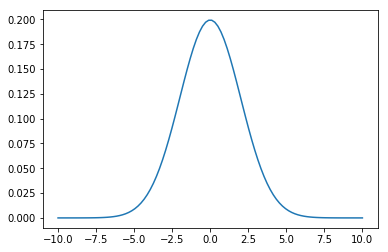

In [18]:
from scipy.stats import norm
mu = 0.0
sigma = 2.0
x = np.linspace(-10., 10, 100)
plt.plot(x, norm(mu,sigma).pdf(x));

Now, take two values $x_1$ and $x_2$. The value taken by $y$ in $x_1$ is not independent of the value in $x_2$; we shall say that $y_1$ and $y_2$ are **correlated**. For example, the pressures $P$ in close $(l,M,T)$ values take values that are linked together.

Let's still suppose the pair $(y_1,y_2)$ follows a Gaussian distribution in $x_1$ and $x_2$, with mean $(\mu_1,\mu_2)$. While the variance in the monovariate case was given by a single scalar $\sigma^2$, now it is given by a covariance matrix $\Sigma = \left[\begin{array}{cc} \sigma_{11} & \sigma_{12}\\ \sigma_{12} & \sigma_{22} \end{array}\right]$ that depicts how the distribution spreads in the $(y_1,y_2)\in\mathbb{R}^2$ plane.

$$\left[\begin{array}{c}y_1\\y_2\end{array}\right] \sim \mathcal{N}\left( \left[\begin{array}{c} \mu_1\\\mu_2\end{array}\right], \Sigma\right)$$

mu = [0.0, 0.0]
sigma:
[[ 2.   0.4]
 [ 0.4  0.5]]


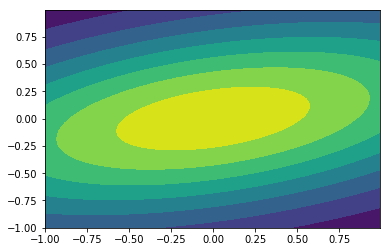

In [19]:
from scipy.stats import multivariate_normal
x,y = np.mgrid[-1:1:.01, -1:1:.01]
pos = np.dstack((x, y))
mu = [0.0, 0.0]
sigma = np.array([[2.0, 0.4], [0.4, 0.5]])
plt.contourf(x, y, multivariate_normal(mu, sigma).pdf(pos));
print("mu =",mu)
print("sigma:")
print(sigma)

The covariance matrix indicates how the values of $y_1$ are centered around $\mu_1$ (through $\sigma_{11}$) and correlated with the value of $y_2$ (through $\sigma_{12}$). In particular, $\sigma_{12}$ indicates how similar the evolution of $y_1$ and $y_2$ are. Suppose we measure a sample $(\hat{y}_1, \hat{y}_2)$:
- having $\sigma_{12}>0$ indicates that if $\hat{y}_1>\mu_1$ then it is likely that $\hat{y}_2>\mu_2$ in a proportional fashion,
- conversely $\sigma_{12}<0$ indicates that $\hat{y}_1$ and $\hat{y}_2$ evolve in opposite directions relatively to their respective means,
- $\sigma_{12}=0$ means that $y_1$ and $y_2$ are independent: a sample of the former gives no information about how likely it is that the latter is greater or smaller than its mean.

If there are $N$ such points $x_i$, and we assume again a Gaussian distribution of $y$, we end up with a mean $(\mu_1,\ldots,\mu_N)$ and a covariance matrix $\Sigma = \left[\begin{array}{ccc} \sigma_{11} & \ldots & \sigma_{1N}\\ \vdots & \ddots & \vdots \\ \sigma_{1N} & \ldots & \sigma_{NN} \end{array}\right]$.

$$\left[\begin{array}{c}y_1\\ \vdots\\y_N \end{array}\right] \sim \mathcal{N}\left( \left[\begin{array}{c} \mu_1\\ \vdots \\ \mu_N\end{array}\right], \Sigma\right)$$

Let's generalize to any number of points:
- The mean becomes $\mu(x)$
- The covariance matrix can be obtained through a **covariance kernel** $k(x,x')$

For a finite set of points $(x_1,\ldots,x_N)$, the corresponding $(y_1,\ldots,y_N)$ follow a Gaussian distribution of mean $(\mu(x_1),\ldots,\mu(x_N))$ and of covariance matrix $\Sigma = \left[\begin{array}{ccc} k(x_1,x_1) & \ldots & k(x_1,x_N)\\ \vdots & \ddots & \vdots \\ k(x_1,x_N) & \ldots & k(x_N,x_N) \end{array}\right]$.

$$\left[\begin{array}{c}y_1\\ \vdots\\y_N \end{array}\right] \sim \mathcal{N}\left( \left[\begin{array}{c} \mu(x_1)\\ \vdots \\ \mu(x_N)\end{array}\right], \Sigma\right)$$

The information of $\mu(x)$ and $k(x,x')$ defines a **Gaussian Process**. If we were able to learn a certain hidden function $f$ as a Gaussian Process, not only would we have the average function that fits $f$ best, but we would also have the probability that any other function fits $f$. In other words, in any new point $x$, we would have the average prediction $\mu(x)$ but also an **uncertainty estimation** through the variance estimate $\sigma(x)$.

## <a id="sec2-2"></a>2.2 Back to the regression problem

So we assume that $y$ is drawn from a Gaussian Process.

Recall that $\mu(x)$ is the mean of the distribution in $x$ and that $k(x,x')$ describes how similar the values of $y$ and $y'$ (resp. in $x$ and $x'$) are likely to be spread around their respective means.

To make things simple, assume that the Gaussian Process describing $f$ has mean zero, so $\mu(x)=0$ everywhere. So what relates an observation to another is just the covariance function $k(x,x')$.

A common covariance function is the so-called **squared exponential**:
$$k(x,x') = \sigma^2 e^{-\frac{(x-x')^2}{2 l^2}}$$

With this covariance function, the correlation between $y$ and $y'$ is high when $x$ and $x'$ are close. As $x$ and $x'$ get further from each other, $y$ and $y'$ tend to become independent.

Since we assume that the observed data $\left\{(x_i,y_i)\right\}_{i=1...N}$ is drawn from a Gaussian distribution and that any new point $(x,y)$ should be drawn from that distribution too, we can write:

$$\left[\begin{array}{c}y_1\\ \vdots\\y_N \\y \end{array}\right] \sim \mathcal{N}\left( 0_{N+1}, \left[\begin{array}{cccc}
k(x_1,x_1) & \ldots & k(x_1,x_N) & k(x_1, x)\\ 
\vdots     & \ddots & \vdots     & \vdots \\
k(x_1,x_N) & \ldots & k(x_N,x_N) & k(x_N,x)\\
k(x_1, x)  & \ldots & k(x_N,x)   & k(x,x)
\end{array}\right] \right)$$

(where $0_{N+1}$ is the $N+1$ dimensional zero vector)

The line above simply states that all points, both the observed data points and the new points on which we wish to make a prediction, are drawn according to the same Gaussian Process. Let's simplify the writing using vector notation. Let's write:
- the data points $\mathbf{y} = \left[y_1,\ldots,y_N\right]$ and $\mathbf{x} = \left[x_1,\ldots,x_N\right]$, 
- the data covariance matrix $K = \left[\begin{array}{ccc}
k(x_1,x_1) & \ldots & k(x_1,x_N)\\ 
\vdots     & \ddots & \vdots\\
k(x_1,x_N) & \ldots & k(x_N,x_N)
\end{array}\right]$
- The cross-covariance vector $K_*(x) = \left[k(x_1, x), \ldots, k(x_N,x)\right]$

Then we have:
$$\left[\begin{array}{c}\mathbf{y}\\y \end{array}\right] \sim \mathcal{N}\left( 0_{N+1}, \left[\begin{array}{cc}
K & K_*(x)^T\\ 
K_*(x) & k(x,x)
\end{array}\right] \right)$$

Let's take a step back. What we have written so far is the probability $\mathbb{P}(\mathbf{y},y|\mathbf{x},x)$. But what we are interested in is the posterior distribution $\mathbb{P}(y|\mathbf{x},\mathbf{y},x)$; that is "the probability of the prediction $y$, given the data $(\mathbf{x},\mathbf{y})$". So let's use Bayes theorem:

$$\mathbb{P}(y|\mathbf{x},\mathbf{y},x) = \frac{\mathbb{P}(\mathbf{y},y|\mathbf{x},x)}{\mathbb{P}(\mathbf{y}|\mathbf{x},x)}$$

Well it appears that because we have assumed that the values were drawn from a Gaussian Process, this posterior follows a Gaussian distribution too:
$$\mathbb{P}(y|\mathbf{x},\mathbf{y},x) = \mathcal{N}\left( K_*(x)K^{-1} \mathbf{y}, k(x,x) - K_*(x) K^{-1} K_*(x)^T\right)$$

Consequently, our best estimate for $y$ is the mean of this distribution:
$$\bar{y} = K_*(x) K^{-1} \mathbf{y}$$

And the uncertainty in this estimate is captured by the variance:
$$\sigma(y)^2 = k(x,x)- K_*(x)K^{-1}K_*(x)^T$$

<div class="alert alert-success"> 
Given the input data $\mathbf{y} = \left[y_1,\ldots,y_N\right]$ and $\mathbf{x} = \left[x_1,\ldots,x_N\right]$, and given a covariance kernel $k(x,x')$, a Gaussian Process regressor estimates the distribution of $y(x)$ as a Gaussian $\mathcal{N}(\mu,\sigma)$ with:
<ul>
<li> $\mu = K_*(x)K^{-1} \mathbf{y}$
<li> $\sigma(y)^2 = k(x,x) - K_*(x)K^{-1}K_*(x)^T$
</ul>
where:
<ul>
<li> $K = \left[\begin{array}{ccc}
k(x_1,x_1) & \ldots & k(x_1,x_N)\\ 
\vdots     & \ddots & \vdots\\
k(x_1,x_N) & \ldots & k(x_N,x_N)
\end{array}\right]$
<li>$K_*(x) = \left[k(x_1, x), \ldots, k(x_N,x)\right]$
</ul>
</div>

Let's take a concrete example.

Suppose the hidden function we want to learn is $f(x) = x \sin(x)$.

Suppose the observation is drawn as $y = f(x) + \mathcal{N}(0, \sigma_n^2)$.

Let's draw 10 data samples and try to obtain the best fit function and confidence intervals.

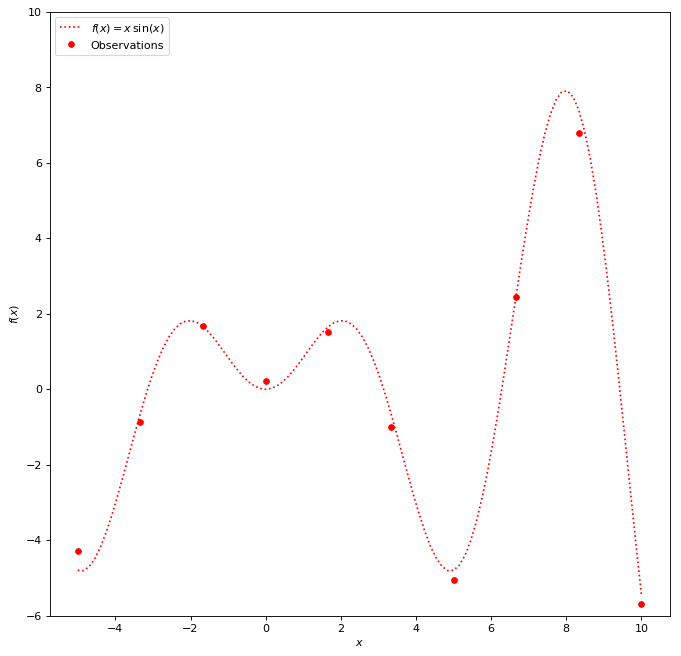

In [42]:
def func(x):
    return x*np.sin(x)

sigma_noise = 0.3
def observation(x):
    return func(x) + np.random.normal(0,sigma_noise,x.shape[0])

X = np.linspace(-5,10,10)
N = X.shape[0]
Y = observation(X)
x = np.linspace(-5,10,100)

fig=plt.figure(figsize=fig_size, dpi= 80, facecolor='w', edgecolor='k')
plt.plot(x, func(x), 'r:', label=u'$f(x) = x\,\sin(x)$')
plt.plot(X, Y, 'r.', markersize=10, label=u'Observations')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-6, 10)
plt.legend(loc='upper left');

To find the best function, we need a covariance kernel. We will take the square exponential kernel with arbitrary $\sigma$ and $l$ parameters and will modify it slightly to account for the measurement noise $\sigma_n$. Then we simply apply the formula above.

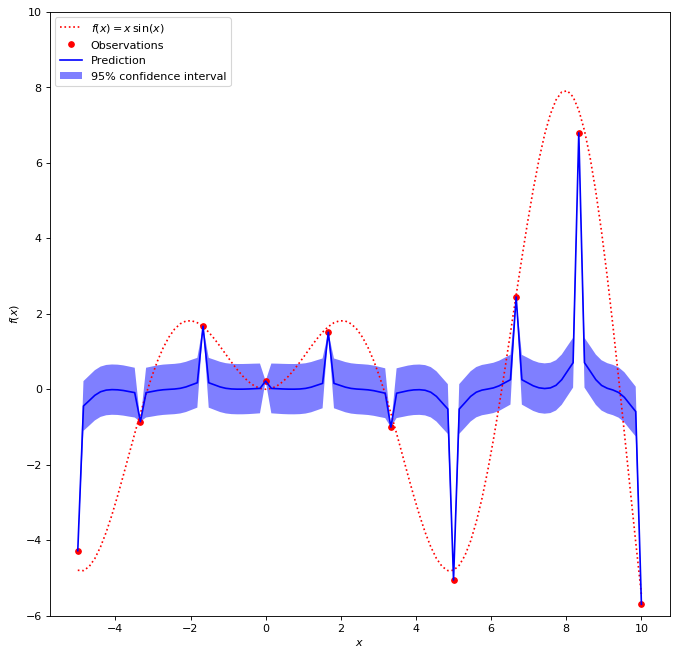

In [43]:
# introduce the square exponential kernel with measurement noise
sigma_kernel = 0.2
l=0.3
def kernel(x1,x2,sigma_kernel,l,sigma_noise):
    return sigma_kernel * sigma_kernel * np.exp(-(x1-x2)**2 / (2*l*l)) + sigma_noise*(x1==x2)

K = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        K[i,j] = kernel(X[i],X[j],sigma_kernel,l,sigma_noise)

Kinv = np.linalg.inv(K)

def GPpredict(x_new, x_data, y_data, Kinv):
    N = y_data.shape[0]
    Kstar = np.zeros((1,N))
    for i in range(N):
        Kstar[0,i] = kernel(x_data[i], x_new, sigma_kernel, l, sigma_noise)
    mu = Kstar @ Kinv @ y_data
    sigma = kernel(x_new,x_new,sigma_kernel,l,sigma_noise) - Kstar @ Kinv @ Kstar.T
    return mu, sigma

x = np.linspace(-5,10,100)
y = np.zeros(x.shape)
sigma = np.zeros(x.shape)
for i in range(x.shape[0]):
    y[i], sigma[i] = GPpredict(x[i], X, Y, Kinv)

fig=plt.figure(figsize=fig_size, dpi= 80, facecolor='w', edgecolor='k')
plt.plot(x, func(x), 'r:', label=u'$f(x) = x\,\sin(x)$')
plt.plot(X, Y, 'r.', markersize=10, label=u'Observations')
plt.plot(x, y, 'b-', label=u'Prediction')
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y - 1.9600 * sigma,
                        (y + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-6, 10)
plt.legend(loc='upper left');

That's quite disappointing. Indeed, the (blue) learned curve goes through the data points but it is far from the (red) original function. An interesting feature however is that the uncertainty reduces almost to zero around the data points and strongly increases elsewhere.

What happened? It seems we made a poor arbitrary choice of kernel parameters. For instance taking $l=0.3$ implies that values $y$ and $y'$ for two points $x$ and $x'$ quickly tend to be independent and so the "influence" of a data point (a red point) does not extend far.

Let's re-run this experiment with other parameters.

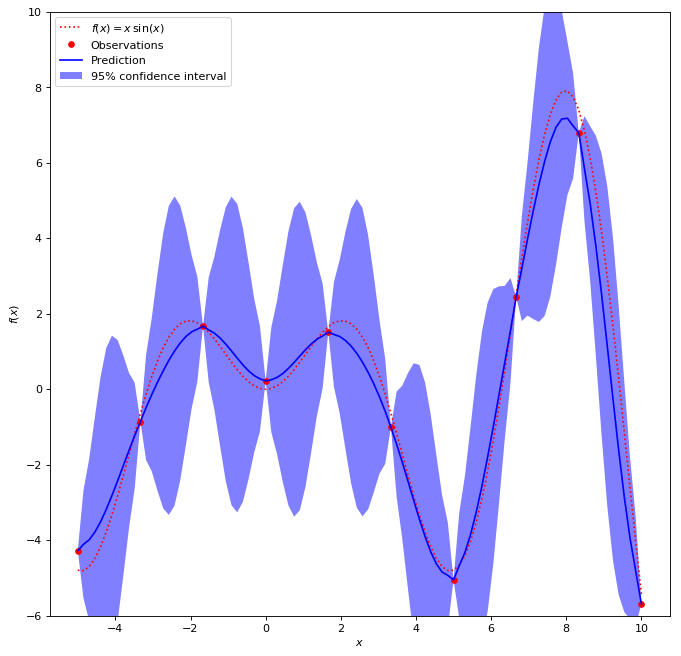

In [44]:
sigma_kernel = 3
l=1
def kernel(x1,x2,sigma_kernel,l,sigma_noise):
    return sigma_kernel * sigma_kernel * np.exp(-(x1-x2)**2 / (2*l*l)) + sigma_noise*(x1==x2)

K = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        K[i,j] = kernel(X[i],X[j],sigma_kernel,l,sigma_noise)

Kinv = np.linalg.inv(K)

def GPpredict(x_new, x_data, y_data, Kinv):
    N = y_data.shape[0]
    Kstar = np.zeros((1,N))
    for i in range(N):
        Kstar[0,i] = kernel(x_data[i], x_new, sigma_kernel, l, sigma_noise)
    mu = Kstar @ Kinv @ y_data
    sigma = kernel(x_new,x_new,sigma_kernel,l,sigma_noise) - Kstar @ Kinv @ Kstar.T
    return mu, sigma

x = np.linspace(-5,10,100)
y = np.zeros(x.shape)
sigma = np.zeros(x.shape)
for i in range(x.shape[0]):
    y[i], sigma[i] = GPpredict(x[i], X, Y, Kinv)

fig=plt.figure(figsize=fig_size, dpi= 80, facecolor='w', edgecolor='k')
plt.plot(x, func(x), 'r:', label=u'$f(x) = x\,\sin(x)$')
plt.plot(X, Y, 'r.', markersize=10, label=u'Observations')
plt.plot(x, y, 'b-', label=u'Prediction')
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y - 1.9600 * sigma,
                        (y + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-6, 10)
plt.legend(loc='upper left');

This starts to look better. The blue curve fits the data points better but it's still not perfect and the uncertainty between data points is actually quite large.

We could wish for an automated way of tuning these kernel parameters. Let's call them $\theta$.

One way to do that is to search for the value of $\theta$ that maximizes the probability of the observed $\mathbf{y}$ given the inputs $\mathbf{x}$. In other words, to find the best $\theta$, we search for the one that explains best the data that we already know, and then use it to make predictions on new points. That is called **Marginal Likelihood Maximization**.

Fortunately for use, scikit-learn includes all these operations in a single procedure.

In [45]:
from sklearn.gaussian_process import GaussianProcessRegressor
gp = GaussianProcessRegressor(n_restarts_optimizer=9)
X=X.reshape(-1,1)
Y=Y.reshape(-1,1)
gp.fit(X,Y)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True, kernel=None,
             n_restarts_optimizer=9, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)

[Hyperparameter(name='k1__constant_value', value_type='numeric', bounds='fixed', n_elements=1, fixed=True), Hyperparameter(name='k2__length_scale', value_type='numeric', bounds='fixed', n_elements=1, fixed=True)]


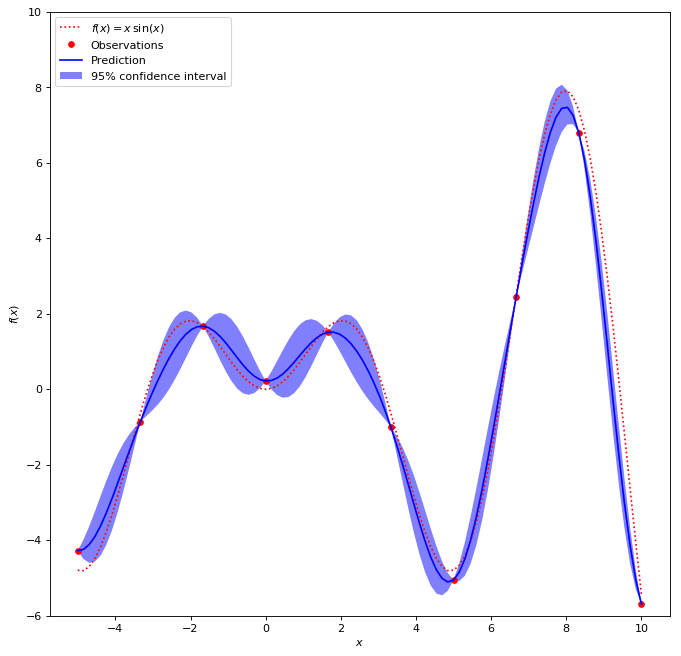

In [46]:
x = np.linspace(-5,10,100)
y = np.zeros(x.shape)
sigma = np.zeros(x.shape)
for i in range(x.shape[0]):
    y[i], sigma[i] = gp.predict(x[i], return_std=True)

fig=plt.figure(figsize=fig_size, dpi= 80, facecolor='w', edgecolor='k')
plt.plot(x, func(x), 'r:', label=u'$f(x) = x\,\sin(x)$')
plt.plot(X, Y, 'r.', markersize=10, label=u'Observations')
plt.plot(x, y, 'b-', label=u'Prediction')
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y - 1.9600 * sigma,
                        (y + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-6, 10)
plt.legend(loc='upper left');
print(gp.kernel_.hyperparameters)

Now that's better. Although the correct function was not found exactly, given the few data points we had it's already a good fit.

Let's summarize a few properties of Gaussian Processes.

<div class="alert alert-success">
<ul>
<li> Gaussian processes are an offline method
<li> They are an optimal method (in the sense of Bayesian inference)
<li> They provide a best fit function, but also error bounds
<li> Given $N$ data points, they require the inversion of an $N\times N$ covariance matrix (complexity in $O(N^3)$)
<li> The kernel encodes the prior knowledge about the function's behaviour.
<li> Careful choice / design of kernels can make GPs a very powerful tool... but can also make them very unstable computationally.
</ul>
</div>

Let's illustrate this last property on a final example, with a periodic function and the "Exp-Sine-Squared" kernel that is commonly used for periodic functions.

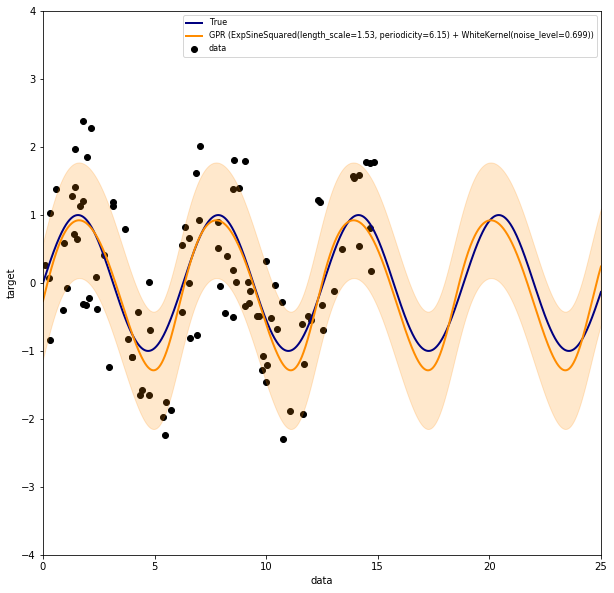

In [49]:
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared

# Generate sample data
rng = np.random.RandomState(0)
X = 15 * rng.rand(100, 1)
y = np.sin(X).ravel()
y += 3 * (0.5 - rng.rand(X.shape[0]))  # add noise

# GP training
gp_kernel = ExpSineSquared(1.0, 5.0, periodicity_bounds=(1e-2, 1e1)) + WhiteKernel(1e-1)
gpr = GaussianProcessRegressor(kernel=gp_kernel)
gpr.fit(X, y)

# GP prediction
X_plot = np.linspace(0, 25, 10000)[:, None]
y_gpr, y_std = gpr.predict(X_plot, return_std=True)

# Plot
plt.figure(figsize=fig_size)
lw = 2
plt.scatter(X, y, c='k', label='data')
plt.plot(X_plot, np.sin(X_plot), color='navy', lw=lw, label='True')
plt.plot(X_plot, y_gpr, color='darkorange', lw=lw,
         label='GPR (%s)' % gpr.kernel_)
plt.fill_between(X_plot[:, 0], y_gpr - y_std, y_gpr + y_std, color='darkorange',
                 alpha=0.2)
plt.xlabel('data')
plt.ylabel('target')
plt.xlim(0, 25)
plt.ylim(-4, 4)
plt.legend(loc="best",  scatterpoints=1, prop={'size': 8})
plt.show()


## <a id="sec2-3"></a>2.3 Gaussian Processes for classification ?

It actually works exactly the same way. For binary classification problems, Gaussian Processes try to predict the probability of belonging to the first class (thus turning back to a regression problem).

# <a id="sec3"></a> 3. Examples

## <a id="sec3-1"></a> 3.1 Spam or ham?

Let's illustrate that on the Ling-spam database.

In [50]:
from sys import path
path.append('../1 - Text data preprocessing')
import load_spam
spam_data = load_spam.spam_data_loader()
spam_data.load_data()
print("data loaded")

Xtrain, ytrain, Xtest, ytest = spam_data.split(2000)

data loaded


In [51]:
Xtrain.shape

(2000, 14279)

We have loaded a training set with 2000 examples. This means that the Gaussian Process training will require inverting a $2000\times2000$ matrix. Although this is still feasible in a few seconds or minutes, we are touching here a limitation of Gaussian Processes in their ability to scale up to large datasets.

In [52]:
from sklearn.gaussian_process import GaussianProcessClassifier

from sklearn.gaussian_process.kernels import RBF

spam_GP = GaussianProcessClassifier(kernel=1.0 * RBF(length_scale=1.0))
spam_GP.fit(Xtrain.toarray(),ytrain)

KeyboardInterrupt: 

In [ ]:
spam_GP.score(Xtest.toarray(),ytest)

For a fair comparison, we can also try the training on the word count features rather than Tf-Idf ones. Although it would probably be more beneficial to search for a better kernel than the default squared exponential one.

In [ ]:
Xtrain, ytrain, Xtest, ytest = spam_data.split(2000, feat='wordcount')
spam_GP = GaussianProcessClassifier(kernel=1.0 * RBF(length_scale=1.0))
spam_GP.fit(Xtrain.toarray(),ytrain)
spam_GP.score(Xtest.toarray(),ytest)

Let's identify which are the misclassified emails.

In [ ]:
# Retrain
Xtrain, ytrain, Xtest, ytest = spam_data.split(2000, feat='wordcount')
spam_GP = GaussianProcessClassifier(n_restarts_optimizer=9)
spam_GP.fit(Xtrain.toarray(),ytrain)

In [ ]:
# Find misclassified examples
misclass = np.not_equal(spam_GP.predict(Xtest.toarray()), ytest)
Xmisclass = Xtest[misclass,:]
ymisclass = ytest[misclass]
misclass_indices = [i for i, j in enumerate(misclass) if j == True]
print("Misclassified messages indices:", misclass_indices)

In [ ]:
# Check some misclassified mails
index = misclass_indices[0]+2000
print("Prediction:", spam_GP.predict(spam_data.word_count[index,:].toarray()))
spam_data.print_email(index)

## <a id="sec3-2"></a> 3.2 NIST

In [ ]:
from sklearn import datasets
%matplotlib inline
import matplotlib.pyplot as plt

digits = datasets.load_digits()
print(digits.data.shape)
print(digits.images.shape)
print(digits.target.shape)
print(digits.target_names)

X = digits.data
y = digits.target
Xtrain,Xtest = np.split(X,[1000])
ytrain,ytest = np.split(y,[1000])
#Xtrain = X[:1000,:]
#ytrain = y[:1000]
#Xtest = X[1000:,:]
#ytest = y[1000:]

plt.gray();
plt.matshow(digits.images[0]);
plt.show();
plt.matshow(digits.images[15]);
plt.show();
plt.matshow(digits.images[42]);
plt.show();

In [ ]:
from sklearn.utils import shuffle

def shuffle_and_split(X,y,n):
    X0,y0 = shuffle(X,y)
    Xtrain,Xtest = np.split(X0,[n])
    ytrain,ytest = np.split(y0,[n])
    return Xtrain, ytrain, Xtest, ytest

In [ ]:
print(Xtrain.shape)
print(ytrain.shape)
digits_gp = GaussianProcessClassifier(n_restarts_optimizer=9)
digits_gp.fit(Xtrain,ytrain)
prediction = digits_gp.predict(Xtest)
#print("Training error:", np.sum(np.not_equal(prediction,ytest))/len(ytest))
print("Generalization error:", np.sum(np.not_equal(prediction,ytest))/len(ytest) )
print("Generalization score:", digits_gp.score(Xtest,ytest))